In [248]:
import numpy as np
import pandas as pd
import pickle, csv
import os

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Reshape,MaxPooling2D, Conv2D, TimeDistributed
from keras import regularizers
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models


from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow.keras.backend as K
K.clear_session()

In [249]:
# Load powerprice data and format it
df_powerprice = pd.read_csv("data/PowerPrice.csv")
df_powerprice["Time"] = pd.to_datetime(df_powerprice["Time"], infer_datetime_format=True)
df_powerprice = df_powerprice.drop(columns=["Time"])
df_powerprice

,DayAhead,Spot,REBAP
0,2.83200,3.688,-4.566
1,2.37575,4.245,-13.964
2,1.91950,3.161,0.345
3,1.46325,1.664,3.048
4,1.00700,3.110,-6.679
...,...,...,...
35035,3.77625,3.342,4.856
35036,3.73900,4.425,8.561
35037,3.70175,2.473,6.076
35038,3.66450,3.241,11.797


In [250]:
# Load spatial data and format it
datasets = []
for filename in os.listdir("data/Spatial"):
    if filename.endswith(".pickle"):
        with open(os.path.join("data/Spatial", filename), "rb") as file:
            data = pickle.load(file)
            if data.shape == (100, 35040):
                datasets.append(data)
            else:
                print(f"Skipping {filename}: unexpected shape {data.shape}")

In [251]:
# Convert the list of arrays to a 3D array
spatial_data = np.stack(datasets, axis=0)

spatial_data = spatial_data.reshape((spatial_data.shape[0], spatial_data.shape[1], spatial_data.shape[2]))

# transpose the second and third dimensions to get shape (13, 35040, 100)
spatial_data = spatial_data.transpose((0, 1, 2))

spatial_data.shape

(13, 100, 35040)

In [252]:
# Load mask and reshape to match desired output shape
mask = pd.read_csv("germany/mask.csv", header=None).values
#mask = mask_df.values.reshape((40, 40, 1))

mask.shape

(30, 30)

In [253]:
spatial_data.shape

(13, 100, 35040)

In [254]:
image_all = np.zeros((35040, 30, 30, 13))
for j in range(spatial_data.shape[2]):
    for i in range(spatial_data.shape[0]):
        image = np.zeros((30, 30))
        for s in range(spatial_data.shape[1]):
            image[mask == s] = spatial_data[i,s,j]
        #print(i)
        image_all[j, :, :, i] = image

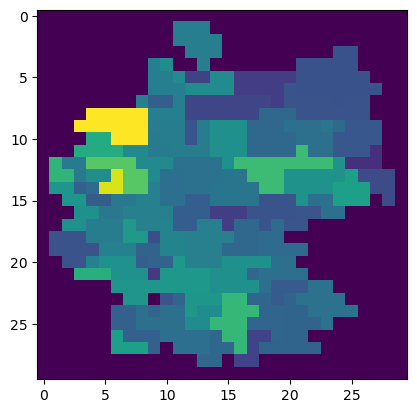

In [255]:
plt.imshow(image_all[35030,:,:,4])
plt.show()

In [256]:
image_all.shape

(35040, 30, 30, 13)

In [257]:
#input_2 = df_powerprice["DayAhead"].values.reshape((-1, 4))
#input_2.shape

In [258]:
output = df_powerprice["Spot"].values

scaler = MinMaxScaler()
output = scaler.fit_transform(output.reshape(-1, 1))

output.shape

(35040, 1)

In [259]:
def split_datasets(df, df2, window_size, look_ahead):
    X = []
    y = []
    for i in range(len(df) - window_size - look_ahead + 1):
        row = df[i:i+window_size, :, :, :]
        X.append(row)
        label = df2[i+window_size+look_ahead-1]
        y.append(label)
    return np.array(X), np.array(y)

In [260]:
window_size = 4
look_ahead = 1
X, y = split_datasets(image_all, output, window_size=window_size, look_ahead=look_ahead)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (35036, 4, 30, 30, 13), y shape: (35036, 1)


In [261]:
# Reshape the input array to a 2D array
input_2d = X.reshape(-1, X.shape[-1])

# Scale the array using MinMaxScaler
scaler = MinMaxScaler()
input_scaled = scaler.fit_transform(input_2d)

# Reshape the scaled array back to the original shape
X = input_scaled.reshape(X.shape)

print("Scaled X shape:", X_scaled.shape)

Scaled X shape: (35036, 4, 30, 30, 13)


In [262]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22422, 4, 30, 30, 13)
y_train shape: (22422, 1)
X_val shape: (5606, 4, 30, 30, 13)
y_val shape: (5606, 1)
X_test shape: (7008, 4, 30, 30, 13)
y_test shape: (7008, 1)


In [263]:
# Add convolutional layers to reduce the image to a 10-dimensional vector

#model.add(Reshape((-1, 30, 30, 13))(X_train.shape))
time_steps =4
width = 30
height = 30
channel = 13
cnn1 = Conv2D(filters=16,kernel_size=(3,3), activation='relu', input_shape=(30,30, 13))
cnn2 = MaxPooling2D(pool_size=(2,2))

cnn3 = Conv2D(filters=32,kernel_size=(3,3),activation='relu')

cnn4 = MaxPooling2D(pool_size=(2,2))

time_series_shape = Input(shape=(time_steps, width, height, channel))

fcnn = Dense(10,activation='relu',name='output')

lstm = LSTM(1, name='lstm1_1')

In [264]:
#model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(30, 30, 13)))

model = Sequential()
model.add(TimeDistributed(cnn1))
model.add(TimeDistributed(cnn2))
model.add(TimeDistributed(cnn3))
model.add(TimeDistributed(cnn4))

model.add(Reshape((-1, 6*6*32)))

model.add(TimeDistributed(fcnn))

model.add(lstm)

#model.add(Flatten())

#model.add(Reshape((-1, -1, -1)))

## Add an LSTM layer to process the sequential data

#model.add(LSTM(units=64, input_shape=(4, 10), return_sequences=False))



# Add a dense layer to produce the final output

#model.add(Dense(units=1, activation='linear'))

In [265]:
# Compile the model with an appropriate optimizer and loss function

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [266]:
# Print a summary of the model architecture

model.build(X_train.shape)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (22422, 4, 28, 28, 16)   1888      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (22422, 4, 14, 14, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (22422, 4, 12, 12, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (22422, 4, 6, 6, 32)     0         
 tributed)                                                       
                                                                 
 reshape (Reshape)           (22422, 4, 1152)          0

In [267]:
# Define callbacks for early stopping and checkpoint saving
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [268]:
cp = ModelCheckpoint(filepath="training/cnn-lstm/", 
                      save_best_only=True,
                      monitor='val_loss', 
                      mode='min', 
                      save_weights_only=False, 
                      verbose=1)

In [269]:
# Fit the model on the training data
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_data=(X_val, y_val), callbacks=[cp, es])

Epoch 1/1000
696/701 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0335
Epoch 1: val_loss improved from inf to 0.00039, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 18s 22ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 3.9126e-04 - val_root_mean_squared_error: 0.0198
Epoch 2/1000
696/701 [============================>.] - ETA: 0s - loss: 2.9404e-04 - root_mean_squared_error: 0.0171
Epoch 2: val_loss improved from 0.00039 to 0.00034, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 2.9349e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.4374e-04 - val_root_mean_squared_error: 0.0185
Epoch 3/1000
700/701 [============================>.] - ETA: 0s - loss: 2.6347e-04 - root_mean_squared_error: 0.0162
Epoch 3: val_loss improved from 0.00034 to 0.00033, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 2.6335e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.2658e-04 - val_root_mean_squared_error: 0.0181
Epoch 4/1000
698/701 [============================>.] - ETA: 0s - loss: 2.4773e-04 - root_mean_squared_error: 0.0157
Epoch 4: val_loss improved from 0.00033 to 0.00031, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 2.4768e-04 - root_mean_squared_error: 0.0157 - val_loss: 3.0564e-04 - val_root_mean_squared_error: 0.0175
Epoch 5/1000
695/701 [============================>.] - ETA: 0s - loss: 2.3887e-04 - root_mean_squared_error: 0.0155
Epoch 5: val_loss improved from 0.00031 to 0.00030, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 2.3848e-04 - root_mean_squared_error: 0.0154 - val_loss: 2.9931e-04 - val_root_mean_squared_error: 0.0173
Epoch 6/1000
698/701 [============================>.] - ETA: 0s - loss: 2.2955e-04 - root_mean_squared_error: 0.0152
Epoch 6: val_loss improved from 0.00030 to 0.00029, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 2.2918e-04 - root_mean_squared_error: 0.0151 - val_loss: 2.8634e-04 - val_root_mean_squared_error: 0.0169
Epoch 7/1000
696/701 [============================>.] - ETA: 0s - loss: 2.2324e-04 - root_mean_squared_error: 0.0149
Epoch 7: val_loss did not improve from 0.00029
701/701 [==============================] - 7s 10ms/step - loss: 2.2510e-04 - root_mean_squared_error: 0.0150 - val_loss: 2.9078e-04 - val_root_mean_squared_error: 0.0171
Epoch 8/1000
698/701 [============================>.] - ETA: 0s - loss: 2.1698e-04 - root_mean_squared_error: 0.0147
Epoch 8: val_loss improved from 0.00029 to 0.00027, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 2.1674e-04 - root_mean_squared_error: 0.0147 - val_loss: 2.7365e-04 - val_root_mean_squared_error: 0.0165
Epoch 9/1000
699/701 [============================>.] - ETA: 0s - loss: 2.1483e-04 - root_mean_squared_error: 0.0147
Epoch 9: val_loss did not improve from 0.00027
701/701 [==============================] - 8s 11ms/step - loss: 2.1456e-04 - root_mean_squared_error: 0.0146 - val_loss: 2.8358e-04 - val_root_mean_squared_error: 0.0168
Epoch 10/1000
695/701 [============================>.] - ETA: 0s - loss: 2.0934e-04 - root_mean_squared_error: 0.0145
Epoch 10: val_loss improved from 0.00027 to 0.00026, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 2.0901e-04 - root_mean_squared_error: 0.0145 - val_loss: 2.6373e-04 - val_root_mean_squared_error: 0.0162
Epoch 11/1000
700/701 [============================>.] - ETA: 0s - loss: 2.0877e-04 - root_mean_squared_error: 0.0144
Epoch 11: val_loss improved from 0.00026 to 0.00026, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 2.0864e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.6287e-04 - val_root_mean_squared_error: 0.0162
Epoch 12/1000
701/701 [==============================] - ETA: 0s - loss: 2.0283e-04 - root_mean_squared_error: 0.0142
Epoch 12: val_loss improved from 0.00026 to 0.00026, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 2.0283e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.5676e-04 - val_root_mean_squared_error: 0.0160
Epoch 13/1000
696/701 [============================>.] - ETA: 0s - loss: 1.9689e-04 - root_mean_squared_error: 0.0140
Epoch 13: val_loss improved from 0.00026 to 0.00025, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 1.9737e-04 - root_mean_squared_error: 0.0140 - val_loss: 2.5193e-04 - val_root_mean_squared_error: 0.0159
Epoch 14/1000
700/701 [============================>.] - ETA: 0s - loss: 1.9436e-04 - root_mean_squared_error: 0.0139
Epoch 14: val_loss did not improve from 0.00025
701/701 [==============================] - 7s 10ms/step - loss: 1.9432e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.6178e-04 - val_root_mean_squared_error: 0.0162
Epoch 15/1000
700/701 [============================>.] - ETA: 0s - loss: 1.9290e-04 - root_mean_squared_error: 0.0139
Epoch 15: val_loss improved from 0.00025 to 0.00025, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.9296e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.4604e-04 - val_root_mean_squared_error: 0.0157
Epoch 16/1000
695/701 [============================>.] - ETA: 0s - loss: 1.9298e-04 - root_mean_squared_error: 0.0139
Epoch 16: val_loss improved from 0.00025 to 0.00024, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.9300e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.4110e-04 - val_root_mean_squared_error: 0.0155
Epoch 17/1000
695/701 [============================>.] - ETA: 0s - loss: 1.9200e-04 - root_mean_squared_error: 0.0139
Epoch 17: val_loss improved from 0.00024 to 0.00024, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 1.9140e-04 - root_mean_squared_error: 0.0138 - val_loss: 2.3781e-04 - val_root_mean_squared_error: 0.0154
Epoch 18/1000
701/701 [==============================] - ETA: 0s - loss: 1.8620e-04 - root_mean_squared_error: 0.0136
Epoch 18: val_loss improved from 0.00024 to 0.00024, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.8620e-04 - root_mean_squared_error: 0.0136 - val_loss: 2.3522e-04 - val_root_mean_squared_error: 0.0153
Epoch 19/1000
696/701 [============================>.] - ETA: 0s - loss: 1.8307e-04 - root_mean_squared_error: 0.0135
Epoch 19: val_loss improved from 0.00024 to 0.00023, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.8263e-04 - root_mean_squared_error: 0.0135 - val_loss: 2.3305e-04 - val_root_mean_squared_error: 0.0153
Epoch 20/1000
697/701 [============================>.] - ETA: 0s - loss: 1.8083e-04 - root_mean_squared_error: 0.0134
Epoch 20: val_loss improved from 0.00023 to 0.00023, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.8082e-04 - root_mean_squared_error: 0.0134 - val_loss: 2.3287e-04 - val_root_mean_squared_error: 0.0153
Epoch 21/1000
699/701 [============================>.] - ETA: 0s - loss: 1.7934e-04 - root_mean_squared_error: 0.0134
Epoch 21: val_loss did not improve from 0.00023
701/701 [==============================] - 7s 10ms/step - loss: 1.7939e-04 - root_mean_squared_error: 0.0134 - val_loss: 2.3814e-04 - val_root_mean_squared_error: 0.0154
Epoch 22/1000
696/701 [============================>.] - ETA: 0s - loss: 1.7719e-04 - root_mean_squared_error: 0.0133
Epoch 22: val_loss improved from 0.00023 to 0.00023, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.7672e-04 - root_mean_squared_error: 0.0133 - val_loss: 2.3102e-04 - val_root_mean_squared_error: 0.0152
Epoch 23/1000
698/701 [============================>.] - ETA: 0s - loss: 1.7506e-04 - root_mean_squared_error: 0.0132
Epoch 23: val_loss improved from 0.00023 to 0.00023, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.7502e-04 - root_mean_squared_error: 0.0132 - val_loss: 2.2919e-04 - val_root_mean_squared_error: 0.0151
Epoch 24/1000
696/701 [============================>.] - ETA: 0s - loss: 1.6767e-04 - root_mean_squared_error: 0.0129
Epoch 24: val_loss improved from 0.00023 to 0.00022, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.7159e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.2109e-04 - val_root_mean_squared_error: 0.0149
Epoch 25/1000
701/701 [==============================] - ETA: 0s - loss: 1.7215e-04 - root_mean_squared_error: 0.0131
Epoch 25: val_loss did not improve from 0.00022
701/701 [==============================] - 7s 10ms/step - loss: 1.7215e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.4293e-04 - val_root_mean_squared_error: 0.0156
Epoch 26/1000
696/701 [============================>.] - ETA: 0s - loss: 1.6887e-04 - root_mean_squared_error: 0.0130
Epoch 26: val_loss did not improve from 0.00022
701/701 [==============================] - 7s 10ms/step - loss: 1.6853e-04 - root_mean_squared_error: 0.0130 - val_loss: 2.4203e-04 - val_root_mean_squared_error: 0.0156
Epoch 27/1000
697/701 [============================>.] - ETA: 0s - loss: 1.6825e-04 - root_mean_squared_error: 0.0130
Epoch 27: val_loss improved from 0.0002

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 1.6802e-04 - root_mean_squared_error: 0.0130 - val_loss: 2.1041e-04 - val_root_mean_squared_error: 0.0145
Epoch 28/1000
698/701 [============================>.] - ETA: 0s - loss: 1.6505e-04 - root_mean_squared_error: 0.0128
Epoch 28: val_loss did not improve from 0.00021
701/701 [==============================] - 8s 11ms/step - loss: 1.6483e-04 - root_mean_squared_error: 0.0128 - val_loss: 2.1823e-04 - val_root_mean_squared_error: 0.0148
Epoch 29/1000
697/701 [============================>.] - ETA: 0s - loss: 1.6591e-04 - root_mean_squared_error: 0.0129
Epoch 29: val_loss improved from 0.00021 to 0.00021, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.6598e-04 - root_mean_squared_error: 0.0129 - val_loss: 2.0897e-04 - val_root_mean_squared_error: 0.0145
Epoch 30/1000
701/701 [==============================] - ETA: 0s - loss: 1.6426e-04 - root_mean_squared_error: 0.0128
Epoch 30: val_loss improved from 0.00021 to 0.00021, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 1.6426e-04 - root_mean_squared_error: 0.0128 - val_loss: 2.0795e-04 - val_root_mean_squared_error: 0.0144
Epoch 31/1000
699/701 [============================>.] - ETA: 0s - loss: 1.6317e-04 - root_mean_squared_error: 0.0128
Epoch 31: val_loss did not improve from 0.00021
701/701 [==============================] - 7s 10ms/step - loss: 1.6321e-04 - root_mean_squared_error: 0.0128 - val_loss: 2.0926e-04 - val_root_mean_squared_error: 0.0145
Epoch 32/1000
699/701 [============================>.] - ETA: 0s - loss: 1.6115e-04 - root_mean_squared_error: 0.0127
Epoch 32: val_loss improved from 0.00021 to 0.00021, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.6100e-04 - root_mean_squared_error: 0.0127 - val_loss: 2.0613e-04 - val_root_mean_squared_error: 0.0144
Epoch 33/1000
695/701 [============================>.] - ETA: 0s - loss: 1.6149e-04 - root_mean_squared_error: 0.0127
Epoch 33: val_loss improved from 0.00021 to 0.00020, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.6093e-04 - root_mean_squared_error: 0.0127 - val_loss: 2.0258e-04 - val_root_mean_squared_error: 0.0142
Epoch 34/1000
695/701 [============================>.] - ETA: 0s - loss: 1.6001e-04 - root_mean_squared_error: 0.0126
Epoch 34: val_loss improved from 0.00020 to 0.00020, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.6017e-04 - root_mean_squared_error: 0.0127 - val_loss: 2.0162e-04 - val_root_mean_squared_error: 0.0142
Epoch 35/1000
700/701 [============================>.] - ETA: 0s - loss: 1.5686e-04 - root_mean_squared_error: 0.0125
Epoch 35: val_loss did not improve from 0.00020
701/701 [==============================] - 7s 10ms/step - loss: 1.5676e-04 - root_mean_squared_error: 0.0125 - val_loss: 2.2257e-04 - val_root_mean_squared_error: 0.0149
Epoch 36/1000
700/701 [============================>.] - ETA: 0s - loss: 1.5731e-04 - root_mean_squared_error: 0.0125
Epoch 36: val_loss did not improve from 0.00020
701/701 [==============================] - 7s 10ms/step - loss: 1.5730e-04 - root_mean_squared_error: 0.0125 - val_loss: 2.0272e-04 - val_root_mean_squared_error: 0.0142
Epoch 37/1000
701/701 [==============================] - ETA: 0s - loss: 1.5517e-04 - root_mean_squared_error: 0.0125
Epoch 37: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.5371e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.9370e-04 - val_root_mean_squared_error: 0.0139
Epoch 39/1000
699/701 [============================>.] - ETA: 0s - loss: 1.5354e-04 - root_mean_squared_error: 0.0124
Epoch 39: val_loss did not improve from 0.00019
701/701 [==============================] - 7s 10ms/step - loss: 1.5339e-04 - root_mean_squared_error: 0.0124 - val_loss: 2.1076e-04 - val_root_mean_squared_error: 0.0145
Epoch 40/1000
699/701 [============================>.] - ETA: 0s - loss: 1.5277e-04 - root_mean_squared_error: 0.0124
Epoch 40: val_loss did not improve from 0.00019
701/701 [==============================] - 7s 10ms/step - loss: 1.5276e-04 - root_mean_squared_error: 0.0124 - val_loss: 2.0238e-04 - val_root_mean_squared_error: 0.0142
Epoch 41/1000
696/701 [============================>.] - ETA: 0s - loss: 1.4992e-04 - root_mean_squared_error: 0.0122
Epoch 41: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 1.4980e-04 - root_mean_squared_error: 0.0122 - val_loss: 1.8892e-04 - val_root_mean_squared_error: 0.0137
Epoch 44/1000
696/701 [============================>.] - ETA: 0s - loss: 1.5096e-04 - root_mean_squared_error: 0.0123
Epoch 44: val_loss did not improve from 0.00019
701/701 [==============================] - 8s 11ms/step - loss: 1.5084e-04 - root_mean_squared_error: 0.0123 - val_loss: 2.0012e-04 - val_root_mean_squared_error: 0.0141
Epoch 45/1000
697/701 [============================>.] - ETA: 0s - loss: 1.4850e-04 - root_mean_squared_error: 0.0122
Epoch 45: val_loss improved from 0.00019 to 0.00019, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 18ms/step - loss: 1.4823e-04 - root_mean_squared_error: 0.0122 - val_loss: 1.8677e-04 - val_root_mean_squared_error: 0.0137
Epoch 46/1000
697/701 [============================>.] - ETA: 0s - loss: 1.4411e-04 - root_mean_squared_error: 0.0120
Epoch 46: val_loss improved from 0.00019 to 0.00018, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.4424e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.8301e-04 - val_root_mean_squared_error: 0.0135
Epoch 47/1000
695/701 [============================>.] - ETA: 0s - loss: 1.4536e-04 - root_mean_squared_error: 0.0121
Epoch 47: val_loss did not improve from 0.00018
701/701 [==============================] - 7s 10ms/step - loss: 1.4477e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.8330e-04 - val_root_mean_squared_error: 0.0135
Epoch 48/1000
694/701 [============================>.] - ETA: 0s - loss: 1.4418e-04 - root_mean_squared_error: 0.0120
Epoch 48: val_loss did not improve from 0.00018
701/701 [==============================] - 7s 10ms/step - loss: 1.4365e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.8669e-04 - val_root_mean_squared_error: 0.0137
Epoch 49/1000
699/701 [============================>.] - ETA: 0s - loss: 1.4309e-04 - root_mean_squared_error: 0.0120
Epoch 49: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.4018e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.7958e-04 - val_root_mean_squared_error: 0.0134
Epoch 52/1000
700/701 [============================>.] - ETA: 0s - loss: 1.4068e-04 - root_mean_squared_error: 0.0119
Epoch 52: val_loss did not improve from 0.00018
701/701 [==============================] - 7s 10ms/step - loss: 1.4060e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.8385e-04 - val_root_mean_squared_error: 0.0136
Epoch 53/1000
695/701 [============================>.] - ETA: 0s - loss: 1.4037e-04 - root_mean_squared_error: 0.0118
Epoch 53: val_loss improved from 0.00018 to 0.00018, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 1.4002e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.7684e-04 - val_root_mean_squared_error: 0.0133
Epoch 54/1000
699/701 [============================>.] - ETA: 0s - loss: 1.3757e-04 - root_mean_squared_error: 0.0117
Epoch 54: val_loss did not improve from 0.00018
701/701 [==============================] - 8s 11ms/step - loss: 1.3765e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.8147e-04 - val_root_mean_squared_error: 0.0135
Epoch 55/1000
700/701 [============================>.] - ETA: 0s - loss: 1.3878e-04 - root_mean_squared_error: 0.0118
Epoch 55: val_loss improved from 0.00018 to 0.00017, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.3875e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.7403e-04 - val_root_mean_squared_error: 0.0132
Epoch 56/1000
699/701 [============================>.] - ETA: 0s - loss: 1.3878e-04 - root_mean_squared_error: 0.0118
Epoch 56: val_loss did not improve from 0.00017
701/701 [==============================] - 7s 11ms/step - loss: 1.3861e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.7775e-04 - val_root_mean_squared_error: 0.0133
Epoch 57/1000
696/701 [============================>.] - ETA: 0s - loss: 1.3601e-04 - root_mean_squared_error: 0.0117
Epoch 57: val_loss improved from 0.00017 to 0.00017, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 18ms/step - loss: 1.3567e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.7377e-04 - val_root_mean_squared_error: 0.0132
Epoch 58/1000
698/701 [============================>.] - ETA: 0s - loss: 1.3725e-04 - root_mean_squared_error: 0.0117
Epoch 58: val_loss improved from 0.00017 to 0.00017, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.3710e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.7115e-04 - val_root_mean_squared_error: 0.0131
Epoch 59/1000
696/701 [============================>.] - ETA: 0s - loss: 1.3412e-04 - root_mean_squared_error: 0.0116
Epoch 59: val_loss did not improve from 0.00017
701/701 [==============================] - 7s 10ms/step - loss: 1.3513e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.7686e-04 - val_root_mean_squared_error: 0.0133
Epoch 60/1000
700/701 [============================>.] - ETA: 0s - loss: 1.3459e-04 - root_mean_squared_error: 0.0116
Epoch 60: val_loss did not improve from 0.00017
701/701 [==============================] - 7s 11ms/step - loss: 1.3460e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.7641e-04 - val_root_mean_squared_error: 0.0133
Epoch 61/1000
696/701 [============================>.] - ETA: 0s - loss: 1.3381e-04 - root_mean_squared_error: 0.0116
Epoch 61: val_loss improved from 0.0001

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 1.3341e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.7086e-04 - val_root_mean_squared_error: 0.0131
Epoch 62/1000
701/701 [==============================] - ETA: 0s - loss: 1.3154e-04 - root_mean_squared_error: 0.0115
Epoch 62: val_loss did not improve from 0.00017
701/701 [==============================] - 7s 10ms/step - loss: 1.3154e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.8210e-04 - val_root_mean_squared_error: 0.0135
Epoch 63/1000
698/701 [============================>.] - ETA: 0s - loss: 1.3184e-04 - root_mean_squared_error: 0.0115
Epoch 63: val_loss did not improve from 0.00017
701/701 [==============================] - 7s 10ms/step - loss: 1.3205e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.7919e-04 - val_root_mean_squared_error: 0.0134
Epoch 64/1000
700/701 [============================>.] - ETA: 0s - loss: 1.3306e-04 - root_mean_squared_error: 0.0115
Epoch 64: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 1.3016e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.6726e-04 - val_root_mean_squared_error: 0.0129
Epoch 67/1000
701/701 [==============================] - ETA: 0s - loss: 1.3001e-04 - root_mean_squared_error: 0.0114
Epoch 67: val_loss improved from 0.00017 to 0.00016, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.3001e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.6383e-04 - val_root_mean_squared_error: 0.0128
Epoch 68/1000
697/701 [============================>.] - ETA: 0s - loss: 1.2882e-04 - root_mean_squared_error: 0.0113
Epoch 68: val_loss did not improve from 0.00016
701/701 [==============================] - 7s 10ms/step - loss: 1.2863e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.7456e-04 - val_root_mean_squared_error: 0.0132
Epoch 69/1000
698/701 [============================>.] - ETA: 0s - loss: 1.2888e-04 - root_mean_squared_error: 0.0114
Epoch 69: val_loss did not improve from 0.00016
701/701 [==============================] - 7s 10ms/step - loss: 1.2873e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.6416e-04 - val_root_mean_squared_error: 0.0128
Epoch 70/1000
700/701 [============================>.] - ETA: 0s - loss: 1.2843e-04 - root_mean_squared_error: 0.0113
Epoch 70: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.2689e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.6227e-04 - val_root_mean_squared_error: 0.0127
Epoch 73/1000
698/701 [============================>.] - ETA: 0s - loss: 1.2828e-04 - root_mean_squared_error: 0.0113
Epoch 73: val_loss improved from 0.00016 to 0.00016, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 1.2843e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.6211e-04 - val_root_mean_squared_error: 0.0127
Epoch 74/1000
700/701 [============================>.] - ETA: 0s - loss: 1.2555e-04 - root_mean_squared_error: 0.0112
Epoch 74: val_loss improved from 0.00016 to 0.00016, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 1.2549e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.5936e-04 - val_root_mean_squared_error: 0.0126
Epoch 75/1000
700/701 [============================>.] - ETA: 0s - loss: 1.2551e-04 - root_mean_squared_error: 0.0112
Epoch 75: val_loss did not improve from 0.00016
701/701 [==============================] - 7s 10ms/step - loss: 1.2549e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.6981e-04 - val_root_mean_squared_error: 0.0130
Epoch 76/1000
701/701 [==============================] - ETA: 0s - loss: 1.2541e-04 - root_mean_squared_error: 0.0112
Epoch 76: val_loss did not improve from 0.00016
701/701 [==============================] - 7s 10ms/step - loss: 1.2541e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.6433e-04 - val_root_mean_squared_error: 0.0128
Epoch 77/1000
701/701 [==============================] - ETA: 0s - loss: 1.2458e-04 - root_mean_squared_error: 0.0112
Epoch 77: val_loss improved from 0.0001

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.2458e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.5903e-04 - val_root_mean_squared_error: 0.0126
Epoch 78/1000
700/701 [============================>.] - ETA: 0s - loss: 1.2396e-04 - root_mean_squared_error: 0.0111
Epoch 78: val_loss did not improve from 0.00016
701/701 [==============================] - 7s 10ms/step - loss: 1.2393e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.6204e-04 - val_root_mean_squared_error: 0.0127
Epoch 79/1000
698/701 [============================>.] - ETA: 0s - loss: 1.2317e-04 - root_mean_squared_error: 0.0111
Epoch 79: val_loss improved from 0.00016 to 0.00016, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 1.2295e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.5828e-04 - val_root_mean_squared_error: 0.0126
Epoch 80/1000
700/701 [============================>.] - ETA: 0s - loss: 1.2266e-04 - root_mean_squared_error: 0.0111
Epoch 80: val_loss improved from 0.00016 to 0.00016, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.2261e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.5713e-04 - val_root_mean_squared_error: 0.0125
Epoch 81/1000
700/701 [============================>.] - ETA: 0s - loss: 1.2274e-04 - root_mean_squared_error: 0.0111
Epoch 81: val_loss did not improve from 0.00016
701/701 [==============================] - 7s 10ms/step - loss: 1.2276e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.6007e-04 - val_root_mean_squared_error: 0.0127
Epoch 82/1000
701/701 [==============================] - ETA: 0s - loss: 1.2194e-04 - root_mean_squared_error: 0.0110
Epoch 82: val_loss improved from 0.00016 to 0.00015, saving model to training/cnn-lstm\


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 19ms/step - loss: 1.2194e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.5372e-04 - val_root_mean_squared_error: 0.0124
Epoch 83/1000
701/701 [==============================] - ETA: 0s - loss: 1.2222e-04 - root_mean_squared_error: 0.0111
Epoch 83: val_loss did not improve from 0.00015
701/701 [==============================] - 8s 11ms/step - loss: 1.2222e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.6109e-04 - val_root_mean_squared_error: 0.0127
Epoch 84/1000
699/701 [============================>.] - ETA: 0s - loss: 1.2233e-04 - root_mean_squared_error: 0.0111
Epoch 84: val_loss did not improve from 0.00015
701/701 [==============================] - 7s 10ms/step - loss: 1.2222e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.5402e-04 - val_root_mean_squared_error: 0.0124
Epoch 85/1000
700/701 [============================>.] - ETA: 0s - loss: 1.2005e-04 - root_mean_squared_error: 0.0110
Epoch 85: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.1800e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.5132e-04 - val_root_mean_squared_error: 0.0123
Epoch 90/1000
694/701 [============================>.] - ETA: 0s - loss: 1.1907e-04 - root_mean_squared_error: 0.0109
Epoch 90: val_loss did not improve from 0.00015
701/701 [==============================] - 7s 10ms/step - loss: 1.1893e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.6103e-04 - val_root_mean_squared_error: 0.0127
Epoch 91/1000
699/701 [============================>.] - ETA: 0s - loss: 1.2056e-04 - root_mean_squared_error: 0.0110
Epoch 91: val_loss did not improve from 0.00015
701/701 [==============================] - 8s 11ms/step - loss: 1.2046e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.5315e-04 - val_root_mean_squared_error: 0.0124
Epoch 92/1000
700/701 [============================>.] - ETA: 0s - loss: 1.1904e-04 - root_mean_squared_error: 0.0109
Epoch 92: val_loss did not improve from

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 19ms/step - loss: 1.1656e-04 - root_mean_squared_error: 0.0108 - val_loss: 1.4808e-04 - val_root_mean_squared_error: 0.0122
Epoch 100/1000
699/701 [============================>.] - ETA: 0s - loss: 1.1542e-04 - root_mean_squared_error: 0.0107
Epoch 100: val_loss did not improve from 0.00015
701/701 [==============================] - 7s 10ms/step - loss: 1.1535e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.5170e-04 - val_root_mean_squared_error: 0.0123
Epoch 101/1000
701/701 [==============================] - ETA: 0s - loss: 1.1471e-04 - root_mean_squared_error: 0.0107
Epoch 101: val_loss did not improve from 0.00015
701/701 [==============================] - 7s 10ms/step - loss: 1.1471e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.5211e-04 - val_root_mean_squared_error: 0.0123
Epoch 102/1000
698/701 [============================>.] - ETA: 0s - loss: 1.1534e-04 - root_mean_squared_error: 0.0107
Epoch 102: val_loss did not improv

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 14s 20ms/step - loss: 1.1237e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.4657e-04 - val_root_mean_squared_error: 0.0121
Epoch 109/1000
697/701 [============================>.] - ETA: 0s - loss: 1.1392e-04 - root_mean_squared_error: 0.0107
Epoch 109: val_loss did not improve from 0.00015
701/701 [==============================] - 7s 10ms/step - loss: 1.1367e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.5057e-04 - val_root_mean_squared_error: 0.0123
Epoch 110/1000
697/701 [============================>.] - ETA: 0s - loss: 1.1192e-04 - root_mean_squared_error: 0.0106
Epoch 110: val_loss did not improve from 0.00015
701/701 [==============================] - 7s 10ms/step - loss: 1.1177e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.5164e-04 - val_root_mean_squared_error: 0.0123
Epoch 111/1000
700/701 [============================>.] - ETA: 0s - loss: 1.1099e-04 - root_mean_squared_error: 0.0105
Epoch 111: val_loss improved from 

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 18ms/step - loss: 1.1099e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.4594e-04 - val_root_mean_squared_error: 0.0121
Epoch 112/1000
699/701 [============================>.] - ETA: 0s - loss: 1.1137e-04 - root_mean_squared_error: 0.0106
Epoch 112: val_loss did not improve from 0.00015
701/701 [==============================] - 7s 10ms/step - loss: 1.1130e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.5654e-04 - val_root_mean_squared_error: 0.0125
Epoch 113/1000
701/701 [==============================] - ETA: 0s - loss: 1.1197e-04 - root_mean_squared_error: 0.0106
Epoch 113: val_loss did not improve from 0.00015
701/701 [==============================] - 7s 11ms/step - loss: 1.1197e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.5076e-04 - val_root_mean_squared_error: 0.0123
Epoch 114/1000
695/701 [============================>.] - ETA: 0s - loss: 1.1119e-04 - root_mean_squared_error: 0.0105
Epoch 114: val_loss improved from 

INFO:tensorflow:Assets written to: training/cnn-lstm\assets


INFO:tensorflow:Assets written to: training/cnn-lstm\assets


701/701 [==============================] - 13s 18ms/step - loss: 1.1105e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.4516e-04 - val_root_mean_squared_error: 0.0120
Epoch 115/1000
697/701 [============================>.] - ETA: 0s - loss: 1.1011e-04 - root_mean_squared_error: 0.0105
Epoch 115: val_loss did not improve from 0.00015
701/701 [==============================] - 9s 13ms/step - loss: 1.0988e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.4749e-04 - val_root_mean_squared_error: 0.0121
Epoch 116/1000
700/701 [============================>.] - ETA: 0s - loss: 1.1075e-04 - root_mean_squared_error: 0.0105
Epoch 116: val_loss did not improve from 0.00015
701/701 [==============================] - 7s 11ms/step - loss: 1.1078e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.6219e-04 - val_root_mean_squared_error: 0.0127
Epoch 117/1000
700/701 [============================>.] - ETA: 0s - loss: 1.1033e-04 - root_mean_squared_error: 0.0105
Epoch 117: val_loss did not improv

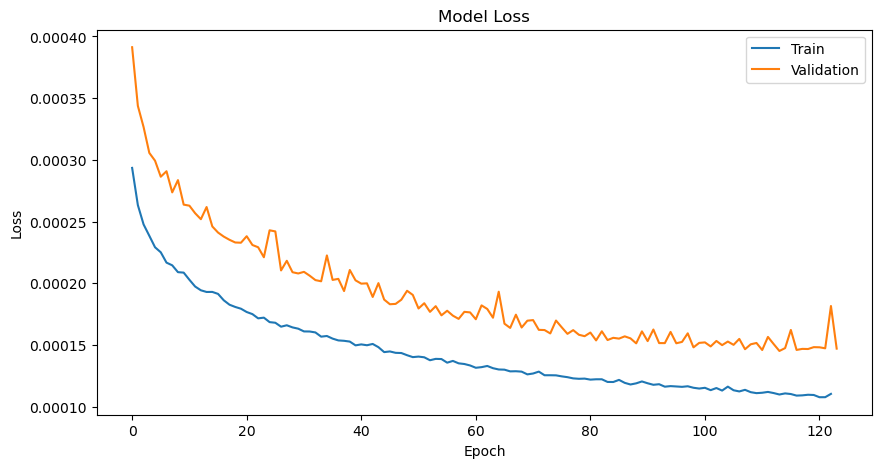

In [270]:
#Plot the training and validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### getting the result of (32, 6, 40, 40, 13)

In [237]:
image = image_slided[np.random.choice(image_slided.shape[0], 32, replace=False)] # just randomly picking the sample from 35035.

image = image.reshape(32, -1, 40, 40, 13)

print(f"image shape: {image.shape}")

image shape: (32, 6, 40, 40, 13)


#### getting the result of (32*6, 40, 40, 13)

In [240]:
image = image.reshape(-1, 40, 40, 13)

image.shape

(192, 40, 40, 13)

In [241]:
df_input = Input(shape=(40, 40, 13))
conv_layer = Conv2D(32, kernel_size=(3,3), activation="relu")(df_input)
conv_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)
conv_layer = Conv2D(64, kernel_size=(3, 3), activation="relu")(conv_layer)
conv_layer = MaxPooling2D(pool_size=(2, 2))(conv_layer)
flatten_layer = Flatten()(conv_layer)
fcnn_layer = Dense(64, activation="relu")(flatten_layer)
fcnn_layer = Dropout(0.2)(fcnn_layer)
fcnn_layer = Dense(32, activation="relu")(fcnn_layer)
fcnn_layer = Dropout(0.2)(fcnn_layer)
fcnn_output = Dense(10, activation="relu")(fcnn_layer)

fcnn_output.shape

TensorShape([None, 10])

In [242]:
model = Model(inputs=df_input, outputs=fcnn_output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 40, 40, 13)]      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 38, 38, 32)        3776      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 19, 19, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0   

In [244]:
# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mse')


In [ ]:
CNN

In [ ]:
(32*6, 4, 4, 32)

In [ ]:
Reshape

In [ ]:
(32*6, 4*4*32)

In [ ]:
FNN

In [ ]:
(32*6, 1)

In [ ]:
Reshape

In [ ]:
(32, 6, 1)